In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import humanize
import plotly.express as px
import warnings
import pymongo
import os

In [2]:
sns.set_style('darkgrid')
plt.rcParams['figure.dpi'] = 80
warnings.filterwarnings('ignore')

In [3]:
client = pymongo.MongoClient(os.getenv('MONGO_URI'))
db = client[os.getenv('MONGO_DATABASE')]
collection = db['scrapy_bogota_apartments_processed']

apartments = pd.DataFrame(list(collection.find()))
apartments = apartments.drop(columns=['_id'], axis=1)
apartments = apartments.loc[(apartments['tipo_operacion'] == 'VENTA') & (apartments['coords_modified'] == False)]

# apartments.head(3)

In [4]:
# apartments = pd.read_csv('../../data/processed/apartments.csv', low_memory=False)
fontibon =  apartments[(apartments['tipo_operacion'] == 'VENTA') & (apartments['localidad'] == 'FONTIBON') & (apartments['coords_modified'] == False)]
fontibon = fontibon.drop(columns=['precio_arriendo'])
fontibon.head()

,codigo,tipo_propiedad,tipo_operacion,precio_venta,area,habitaciones,banos,administracion,parqueaderos,sector,...,vigilancia,coords_modified,localidad,barrio,estacion_tm_cercana,distancia_estacion_tm_m,is_cerca_estacion_tm,parque_cercano,distancia_parque_m,is_cerca_parque
33,3440691,APARTAMENTO,VENTA,550000000.0,89.0,3.0,2.0,330000.0,1.0,MODELIA,...,0.0,False,FONTIBON,LA ESPERANZA_,Av. Rojas – UNISALESIANA,1237.55,0,PARQUE VECINAL CARLOS LLERAS (EL FUEGO),531.16,0
48,4269720,APARTAMENTO,VENTA,398000000.0,78.0,3.0,2.0,295200.0,1.0,GRANJAS DE TECHO,...,0.0,False,FONTIBON,URB. PRADO GRANDE,Modelia,2591.61,0,PARQUE VECINAL VILLA HELENA VILLEMAR,1150.78,0
54,4202115,APARTAMENTO,VENTA,255000000.0,63.0,3.0,2.0,188700.0,0.0,GRANJAS DE TECHO,...,0.0,False,FONTIBON,URB. CAPELLANIA,Portal El Dorado,2116.57,0,PARQUE VECINAL VILLA HELENA VILLEMAR,543.41,0
71,3707497,APARTAMENTO,VENTA,335000000.0,67.0,3.0,2.0,374500.0,1.0,GRANJAS DE TECHO,...,0.0,False,FONTIBON,URB. PRADO GRANDE,Modelia,2456.26,0,PARQUE VECINAL VILLA HELENA VILLEMAR,664.41,0
72,4174031,CASA CON CONJUNTO CERRADO,VENTA,147430500.0,52.0,2.0,1.0,NaN,0.0,ZONA FRANCA,...,0.0,False,FONTIBON,S.C. EL CHARCO (RURAL),Biblioteca Tintal,4794.33,0,PARQUE METROPOLITANO ZONA FRANCA,1516.58,0


In [6]:
fontibon.datetime = pd.to_datetime(fontibon.datetime)
fontibon['last_view'] = pd.to_datetime(fontibon['last_view'])

In [7]:
fontibon.shape

(1056, 44)

In [8]:
fontibon.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1056 entries, 33 to 42961
Data columns (total 44 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   codigo                   1056 non-null   object        
 1   tipo_propiedad           1056 non-null   object        
 2   tipo_operacion           1056 non-null   object        
 3   precio_venta             1056 non-null   float64       
 4   area                     1056 non-null   float64       
 5   habitaciones             1056 non-null   float64       
 6   banos                    1056 non-null   float64       
 7   administracion           937 non-null    float64       
 8   parqueaderos             1056 non-null   float64       
 9   sector                   988 non-null    object        
 10  estrato                  1056 non-null   float64       
 11  antiguedad               1056 non-null   object        
 12  latitud                  1056 non-nul

In [9]:
fontibon.columns

Index(['codigo', 'tipo_propiedad', 'tipo_operacion', 'precio_venta', 'area',
       'habitaciones', 'banos', 'administracion', 'parqueaderos', 'sector',
       'estrato', 'antiguedad', 'latitud', 'longitud', 'direccion',
       'descripcion', 'website', 'last_view', 'datetime', 'url', 'timeline',
       'estado', 'compañia', 'jacuzzi', 'piso', 'closets', 'chimenea',
       'permite_mascotas', 'gimnasio', 'ascensor', 'conjunto_cerrado',
       'piscina', 'salon_comunal', 'terraza', 'vigilancia', 'coords_modified',
       'localidad', 'barrio', 'estacion_tm_cercana', 'distancia_estacion_tm_m',
       'is_cerca_estacion_tm', 'parque_cercano', 'distancia_parque_m',
       'is_cerca_parque'],
      dtype='object')

In [10]:
def format_tick_humanize(value, tick_number):
    return humanize.intword(value)

# Eliminar outliers

Eliminamos los precios que son outliers

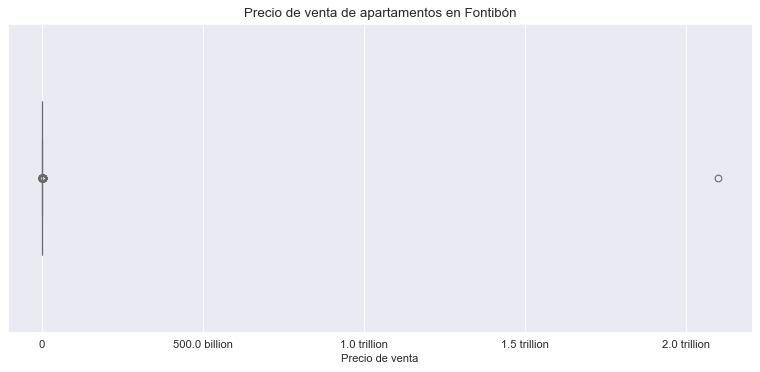

In [11]:
plt.figure(figsize=(12, 5))

sns.boxplot(
    fontibon,
    x='precio_venta',
    width=.5,
    palette='Set3',
)

plt.title('Precio de venta de apartamentos en Fontibón')
plt.xlabel('Precio de venta')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

In [12]:
Q1 = fontibon['precio_venta'].quantile(0.25)
Q3 = fontibon['precio_venta'].quantile(0.75)

IQR = Q3 - Q1

lower = Q1 - (1.5 * IQR)
if lower < 0:
    lower = Q1 - (0.5 * IQR)
upper = Q3 + (1.5 * IQR)

outliers = fontibon[(fontibon['precio_venta'] < lower) | (fontibon['precio_venta'] > upper)]
outliers.shape

(71, 44)

In [13]:
fontibon = fontibon[(fontibon['precio_venta'] > lower) & (fontibon['precio_venta'] < upper)]
fontibon.shape

(985, 44)

# Analisis Univariado

## Area (m2)

### Eliminar outliers

In [14]:
# eliminar area igual a 0

fontibon = fontibon[fontibon['area'] > 0]

Eliminamos las areas (m2) que son outliers

In [15]:
Q1 = fontibon['area'].quantile(0.25)
Q3 = fontibon['area'].quantile(0.75)

IQR = Q3 - Q1

lower = Q1 - (1.5 * IQR)
upper = Q3 + (1.5 * IQR)

outliers = fontibon[(fontibon['area'] < lower) | (fontibon['area'] > upper)]
outliers.shape

(21, 44)

In [16]:
fontibon = fontibon[(fontibon['area'] > lower) & (fontibon['area'] < upper)]
fontibon.shape

(964, 44)

### Analisis

In [17]:
fontibon.area.describe().apply(lambda x: humanize.intcomma(x)).to_frame().T

,count,mean,std,min,25%,50%,75%,max
area,964.0,68.78702282157677,22.07595285486345,20.0,50.2625,65.47999999999999,85.0,138.0


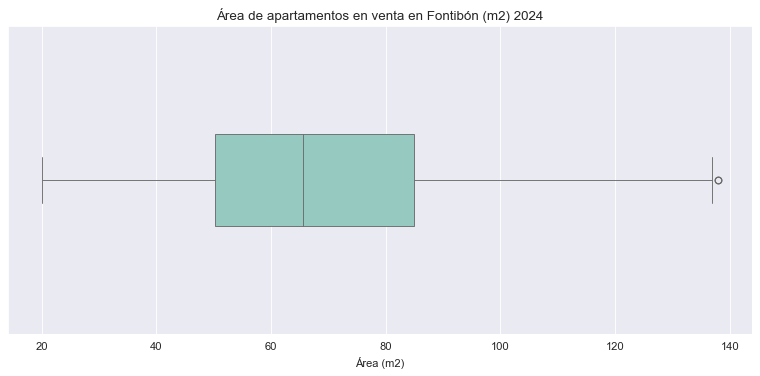

In [19]:
plt.figure(figsize=(12, 5))

sns.boxplot(
    data=fontibon,
    x='area',
    width=.3,
    palette='Set3',
    linewidth=.8,
)

plt.title('Área de apartamentos en venta en Fontibón (m2) 2024')
plt.xlabel('Área (m2)')
plt.show()

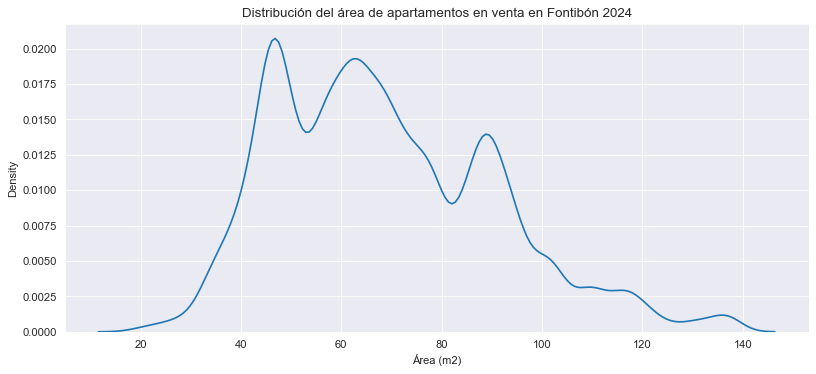

In [20]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    fontibon,
    x='area',
    bw_adjust=.5,
)

plt.title('Distribución del área de apartamentos en venta en Fontibón 2024')
plt.xlabel('Área (m2)')
plt.show()

### Cercania a Transmilenio

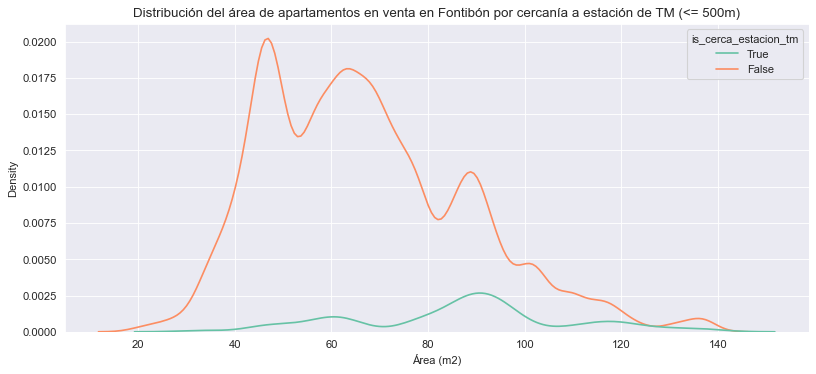

In [22]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    fontibon,
    x='area',
    bw_adjust=.5,
    hue='is_cerca_estacion_tm',
    palette='Set2',
    hue_order=[True, False],
)

plt.title('Distribución del área de apartamentos en venta en Fontibón por cercanía a estación de TM (<= 500m)')
plt.xlabel('Área (m2)')
plt.show()

In [28]:
fontibon['is_cerca_estacion_tm'].value_counts()

is_cerca_estacion_tm
0    880
1     84
Name: count, dtype: int64

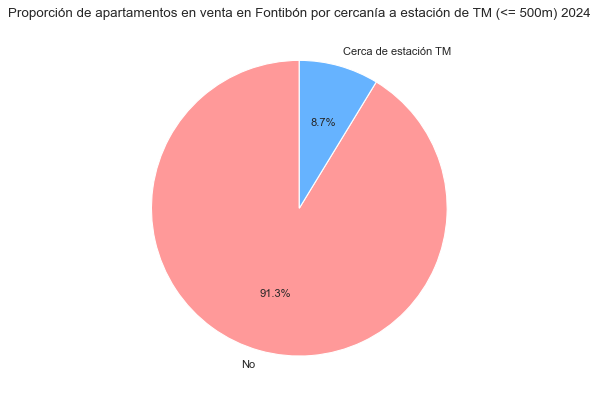

In [30]:
# pie chart

plt.figure(figsize=(6, 6))

fontibon['is_cerca_estacion_tm'].value_counts().plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    colors=['#ff9999', '#66b3ff'],
    labels=['No', 'Cerca de estación TM'],
)

plt.title('Proporción de apartamentos en venta en Fontibón por cercanía a estación de TM (<= 500m) 2024')
plt.ylabel('')
plt.show()


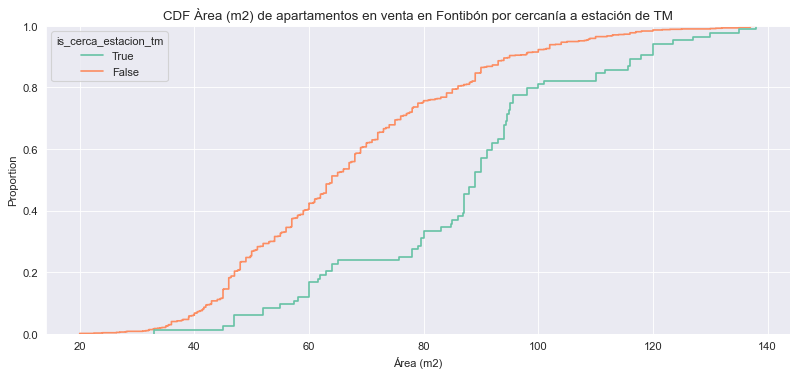

In [31]:
plt.figure(figsize=(12, 5))

sns.ecdfplot(
    fontibon,
    x='area',
    hue='is_cerca_estacion_tm',
    palette='Set2',
    hue_order=[True, False],
)

plt.title('CDF Àrea (m2) de apartamentos en venta en Fontibón por cercanía a estación de TM')
plt.xlabel('Área (m2)')
plt.show()


### Estrato

In [32]:
fontibon.groupby('estrato')['area'].describe().applymap(lambda x: round(x, 1))

,count,mean,std,min,25%,50%,75%,max
estrato,,,,,,,,
2.0,42.0,48.0,7.9,24.0,44.2,50.3,54.8,59.0
3.0,278.0,52.3,14.1,22.5,45.0,48.0,59.0,130.0
4.0,582.0,76.1,19.7,20.0,63.0,74.0,89.0,138.0
5.0,62.0,88.3,24.9,33.0,67.9,91.0,101.8,138.0


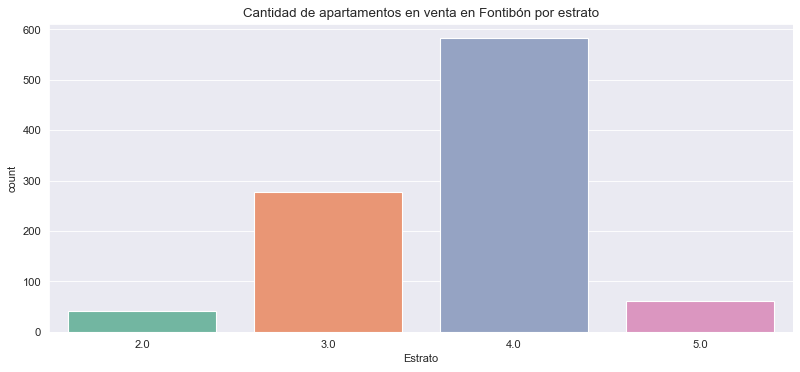

In [33]:
plt.figure(figsize=(12, 5))

sns.countplot(
    data=fontibon,
    x='estrato',
    palette='Set2',
)

plt.title('Cantidad de apartamentos en venta en Fontibón por estrato')
plt.xlabel('Estrato')
plt.show()

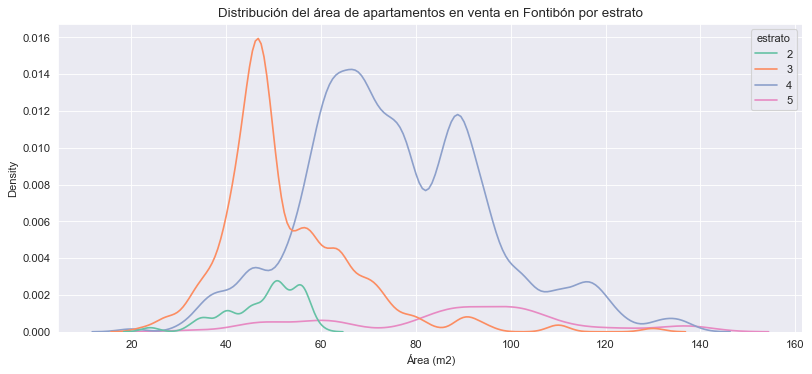

In [34]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    fontibon,
    x='area',
    bw_adjust=.5,
    hue='estrato',
    hue_order=[2, 3, 4, 5],
    palette='Set2',
)

plt.title('Distribución del área de apartamentos en venta en Fontibón por estrato')
plt.xlabel('Área (m2)')
plt.show()

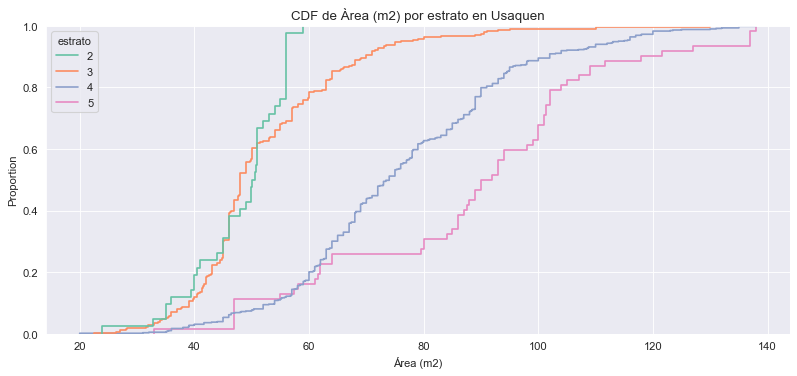

In [35]:
plt.figure(figsize=(12, 5))

sns.ecdfplot(
    fontibon,
    x='area',
    hue='estrato',
    palette='Set2',
    hue_order=[2, 3, 4, 5],
)

plt.title('CDF de Àrea (m2) por estrato en Usaquen')
plt.xlabel('Área (m2)')
plt.show()

### Antiguedad

In [36]:
fontibon.groupby('antiguedad')['area'].describe().applymap(lambda x: round(x, 1))

,count,mean,std,min,25%,50%,75%,max
antiguedad,,,,,,,,
EN CONSTRUCCION,13.0,47.9,15.1,28.2,37.7,40.7,59.4,73.4
ENTRE 0 Y 5 ANOS,281.0,58.8,20.5,22.5,45.0,50.4,72.0,137.0
ENTRE 10 Y 20 ANOS,259.0,74.2,18.2,36.0,60.0,71.0,89.0,127.0
ENTRE 5 Y 10 ANOS,165.0,71.8,24.7,26.4,50.0,69.0,85.0,138.0
MAS DE 20 ANOS,206.0,75.3,21.7,20.0,60.9,70.5,90.0,135.0
PARA ESTRENAR,7.0,60.9,17.3,39.8,49.1,61.5,70.2,86.5
REMODELADO,29.0,69.2,19.8,36.0,58.2,68.2,73.0,123.5
SOBRE PLANOS,4.0,43.1,11.5,36.0,36.0,38.2,45.3,60.0


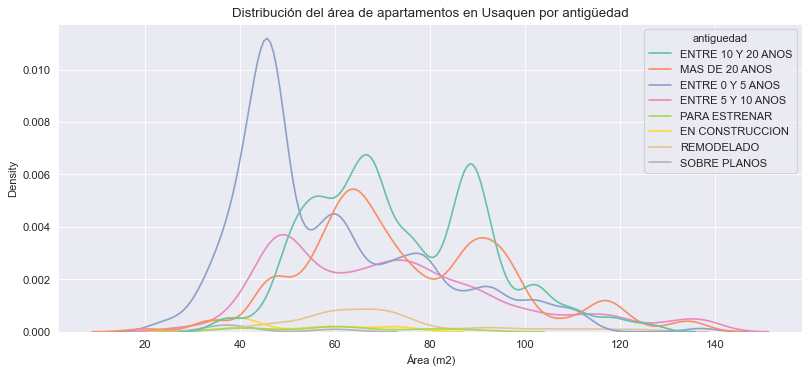

In [37]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    fontibon,
    x='area',
    bw_adjust=.5,
    hue='antiguedad',
    palette='Set2',
)

plt.title('Distribución del área de apartamentos en Usaquen por antigüedad')
plt.xlabel('Área (m2)')
plt.show()

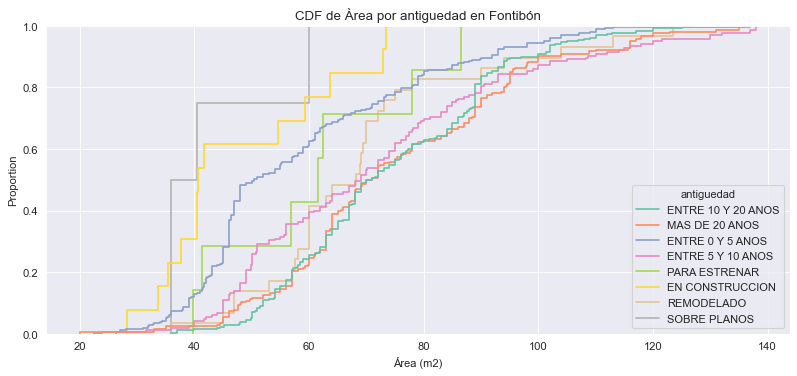

In [38]:
plt.figure(figsize=(12, 5))

sns.ecdfplot(
    fontibon,
    x='area',
    hue='antiguedad',
    palette='Set2',
)

plt.title('CDF de Àrea por antiguedad en Fontibón')
plt.xlabel('Área (m2)')
plt.show()

Lo apartamentos mas recientes tienden a tener un Àrea menor que los mas antiguos

### Estacion de TM Cercana

In [39]:
estacion_tm_cercana = fontibon[fontibon['is_cerca_estacion_tm'] == True]
estacion_tm_cercana_stats = estacion_tm_cercana.groupby('estacion_tm_cercana')['area'].describe().applymap(lambda x: round(x, 1)).sort_values(by='mean', ascending=False)
estacion_tm_cercana_stats

,count,mean,std,min,25%,50%,75%,max
estacion_tm_cercana,,,,,,,,
El Tiempo – Cámara de Comercio de Bogotá,30.0,91.8,13.8,58.0,87.0,91.5,95.4,127.0
Modelia,6.0,89.1,24.4,45.0,88.8,94.0,94.4,120.0
Salitre - El Greco,1.0,89.0,NaN,89.0,89.0,89.0,89.0,89.0
Normandía,20.0,84.9,27.8,47.0,60.0,83.4,101.0,138.0
Av. Rojas – UNISALESIANA,27.0,82.3,25.2,33.0,62.5,85.0,93.9,135.0


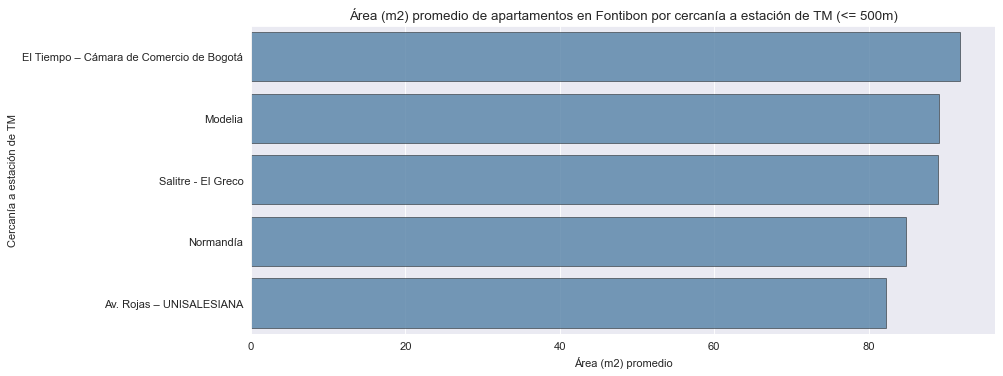

In [40]:
plt.figure(figsize=(12, 5))

sns.barplot(
    estacion_tm_cercana_stats,
    y=estacion_tm_cercana_stats.index,
    x='mean',
    # palette='Set2',
    color='steelblue',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Área (m2) promedio de apartamentos en Fontibon por cercanía a estación de TM (<= 500m)')
plt.xlabel('Área (m2) promedio')
plt.ylabel('Cercanía a estación de TM')
plt.show()

In [41]:
estacion_tm_cercana_stats = estacion_tm_cercana.groupby('estacion_tm_cercana')['area'].describe().applymap(lambda x: round(x, 1)).sort_values(by='50%', ascending=False)

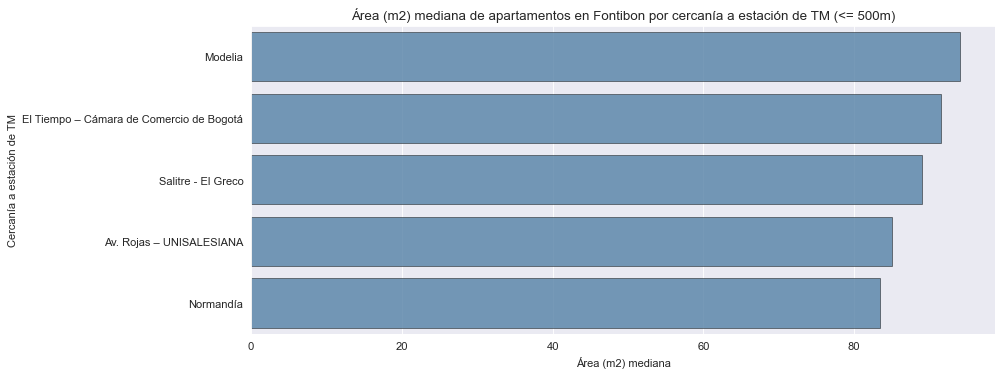

In [42]:
plt.figure(figsize=(12, 5))

sns.barplot(
    estacion_tm_cercana_stats,
    y=estacion_tm_cercana_stats.index,
    x='50%',
    # palette='Set2',
    color='steelblue',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Área (m2) mediana de apartamentos en Fontibon por cercanía a estación de TM (<= 500m)')
plt.xlabel('Área (m2) mediana')
plt.ylabel('Cercanía a estación de TM')
plt.show()

<Figure size 960x400 with 0 Axes>

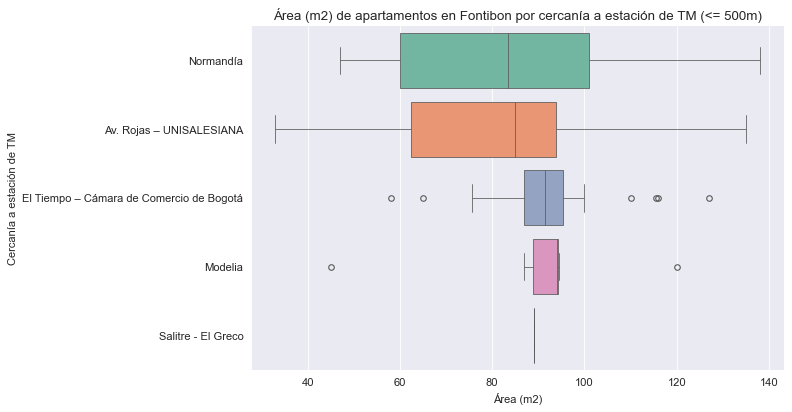

In [43]:
plt.figure(figsize=(12, 5))

sns.catplot(
    data=estacion_tm_cercana,
    x='area',
    y='estacion_tm_cercana',
    kind='box',
    height=5,
    aspect=2,
    palette='Set2',
    orient='h',
    linewidth=.7,
)

plt.title('Área (m2) de apartamentos en Fontibon por cercanía a estación de TM (<= 500m)')
plt.xlabel('Área (m2)')
plt.ylabel('Cercanía a estación de TM')
plt.show()

## Precio de venta

In [46]:
MAPBOX_TOKEN = os.getenv('MAPBOX_TOKEN')

px.set_mapbox_access_token(MAPBOX_TOKEN)

fig = px.scatter_mapbox(
    fontibon,
    lat='latitud',
    lon='longitud',
    color='precio_venta',
    size='area',
    color_continuous_scale=px.colors.cyclical.IceFire,
    size_max=15,
    zoom=11,
    title='Precio de venta y área de apartamentos en Fontibon',
    hover_name='barrio',
    hover_data=['area', 'precio_venta', 'estrato', 'antiguedad', 'is_cerca_estacion_tm', 'estacion_tm_cercana'],
)

fig.update_layout(
    margin=dict(l=0, r=0, t=50, b=0),
    coloraxis_colorbar=dict(
        title='Precio de venta',
        tickformat='s',
    ),
    mapbox=dict(
        style='basic',
    ),
)

fig.write_html('../../html/fontibon_precios_area.html')
fig.show()

In [47]:
fontibon.precio_venta.describe().apply(lambda x: humanize.intword(x)).to_frame().T

,count,mean,std,min,25%,50%,75%,max
precio_venta,964,416.3 million,205.6 million,119.9 million,250.0 million,364.6 million,550.0 million,1.1 billion


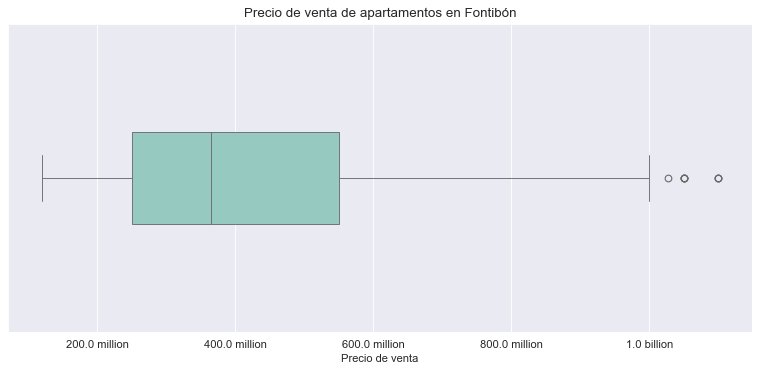

In [48]:
plt.figure(figsize=(12, 5))

sns.boxplot(
    fontibon,
    x='precio_venta',
    width=.3,
    palette='Set3',
    linewidth=.8,
)

plt.title('Precio de venta de apartamentos en Fontibón')
plt.xlabel('Precio de venta')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

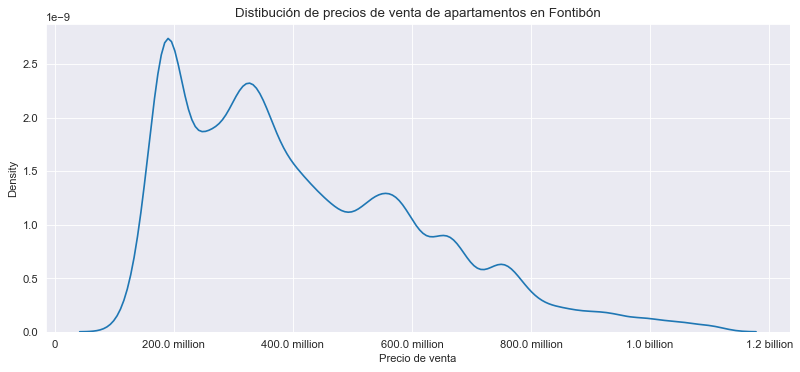

In [49]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    fontibon,
    x='precio_venta',
    bw_adjust=.5,
)

plt.title('Distibución de precios de venta de apartamentos en Fontibón')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

### Barrios

In [50]:
top_barrios = fontibon.groupby('barrio').agg(
    count=('barrio', 'count'),
    mean=('precio_venta', 'mean'),
    median=('precio_venta', 'median'),
    std=('precio_venta', 'std'),
)

# escoger los que tienen más de 20 registros para que sea más representativo
top_barrios_mean = top_barrios[top_barrios['count'] > 20].sort_values('mean', ascending=False).head(10)
top_barrios_mean.applymap(lambda x: humanize.intword(x))

,count,mean,median,std
barrio,,,,
LA ESPERANZA NORTE,37,745.0 million,750.0 million,186.5 million
CIUDAD SALITRE OCCIDENTAL,49,692.1 million,660.0 million,162.8 million
CIUDAD SALITRE 3 A. ETAPA,23,661.3 million,677.0 million,131.5 million
CIUDAD SALITRE,31,566.1 million,561.0 million,105.3 million
MODELIA,25,561.5 million,485.0 million,182.3 million
LA ESPERANZA_,92,545.0 million,562.5 million,178.5 million
INTERINDUSTRIAL - EL VERGEL,29,472.6 million,535.0 million,113.6 million
EL TINTAL A.S.D.,120,441.0 million,399.5 million,165.9 million
MODELIA OCCIDENTAL,29,415.3 million,410.0 million,99.9 million


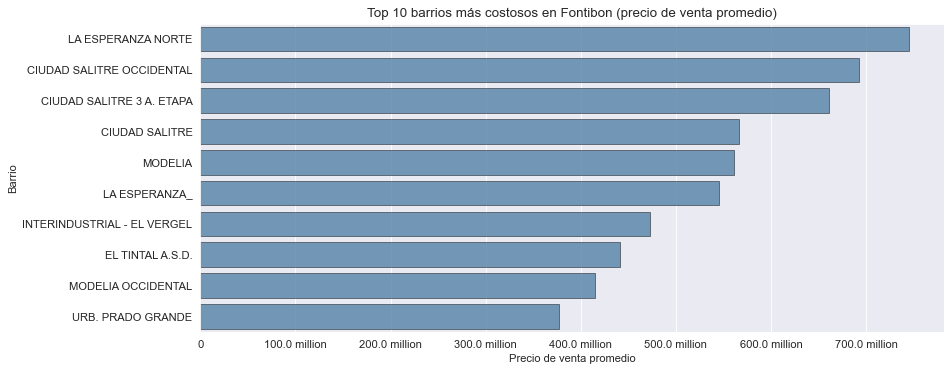

In [51]:
plt.figure(figsize=(12, 5), dpi=80)

sns.barplot(
    top_barrios_mean,
    y=top_barrios_mean.index,
    x='mean',
    color='steelblue',
    # palette='Set1',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Top 10 barrios más costosos en Fontibon (precio de venta promedio)')
plt.xlabel('Precio de venta promedio')
plt.ylabel('Barrio')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))

plt.show()

In [52]:
top_barrios_median = top_barrios[top_barrios['count'] > 20].sort_values('median', ascending=False).head(10)
top_barrios_median.applymap(lambda x: humanize.intword(x))

,count,mean,median,std
barrio,,,,
LA ESPERANZA NORTE,37,745.0 million,750.0 million,186.5 million
CIUDAD SALITRE 3 A. ETAPA,23,661.3 million,677.0 million,131.5 million
CIUDAD SALITRE OCCIDENTAL,49,692.1 million,660.0 million,162.8 million
LA ESPERANZA_,92,545.0 million,562.5 million,178.5 million
CIUDAD SALITRE,31,566.1 million,561.0 million,105.3 million
INTERINDUSTRIAL - EL VERGEL,29,472.6 million,535.0 million,113.6 million
MODELIA,25,561.5 million,485.0 million,182.3 million
MODELIA OCCIDENTAL,29,415.3 million,410.0 million,99.9 million
EL TINTAL A.S.D.,120,441.0 million,399.5 million,165.9 million


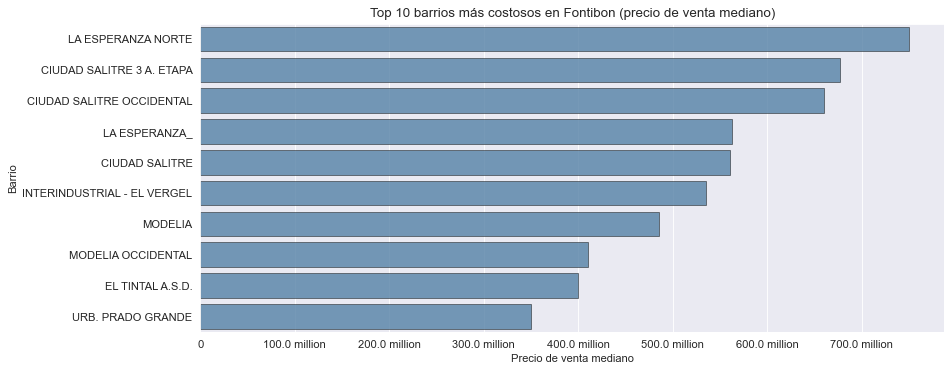

In [53]:
plt.figure(figsize=(12, 5))

sns.barplot(
    top_barrios_median,
    y=top_barrios_median.index,
    x='median',
    color='steelblue',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Top 10 barrios más costosos en Fontibon (precio de venta mediano)')
plt.xlabel('Precio de venta mediano')
plt.ylabel('Barrio')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

In [54]:
top_barrios_economicos = fontibon.groupby('barrio').agg(
    count=('barrio', 'count'),
    mean=('precio_venta', 'mean'),
    median=('precio_venta', 'median'),
    std=('precio_venta', 'std'),
)

top_barrios_economicos_mean = top_barrios_economicos[top_barrios_economicos['count'] > 10].sort_values('mean', ascending=True).head(10)
top_barrios_economicos_mean.applymap(lambda x: humanize.intword(x))

,count,mean,median,std
barrio,,,,
EL CHARCO,102,183.4 million,184.9 million,17.4 million
S.C. PUENTE GRANDE,14,229.6 million,195.0 million,122.2 million
URB. COFRADIA II SECTOR,13,262.0 million,264.0 million,5.6 million
VILLEMAR,29,304.6 million,292.3 million,87.5 million
CAPELLANIA,40,319.9 million,310.0 million,52.8 million
CENTRO FONTIBON,17,330.2 million,250.0 million,192.7 million
URB. PRADO GRANDE,83,376.8 million,350.0 million,81.9 million
S.C. EL TINTAL CENTRAL,16,391.9 million,352.5 million,70.5 million
URB. LOS HAYUELOS,11,400.0 million,410.0 million,48.1 million


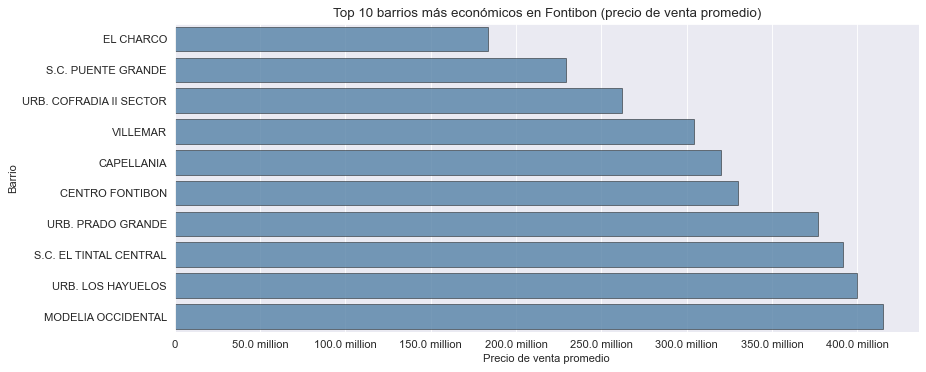

In [55]:
plt.figure(figsize=(12, 5))

sns.barplot(
    top_barrios_economicos_mean,
    y=top_barrios_economicos_mean.index,
    x='mean',
    color='steelblue',
    # palette='Set1',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Top 10 barrios más económicos en Fontibon (precio de venta promedio)')
plt.xlabel('Precio de venta promedio')
plt.ylabel('Barrio')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))

plt.show()

In [56]:
top_barrios_economicos_median = top_barrios_economicos[top_barrios_economicos['count'] > 10].sort_values('median', ascending=True).head(10)
top_barrios_economicos_median.applymap(lambda x: humanize.intword(x))

,count,mean,median,std
barrio,,,,
EL CHARCO,102,183.4 million,184.9 million,17.4 million
S.C. PUENTE GRANDE,14,229.6 million,195.0 million,122.2 million
CENTRO FONTIBON,17,330.2 million,250.0 million,192.7 million
URB. COFRADIA II SECTOR,13,262.0 million,264.0 million,5.6 million
VILLEMAR,29,304.6 million,292.3 million,87.5 million
CAPELLANIA,40,319.9 million,310.0 million,52.8 million
SANTA_CECILIA,18,435.4 million,347.5 million,155.8 million
URB. PRADO GRANDE,83,376.8 million,350.0 million,81.9 million
S.C. EL TINTAL CENTRAL,16,391.9 million,352.5 million,70.5 million


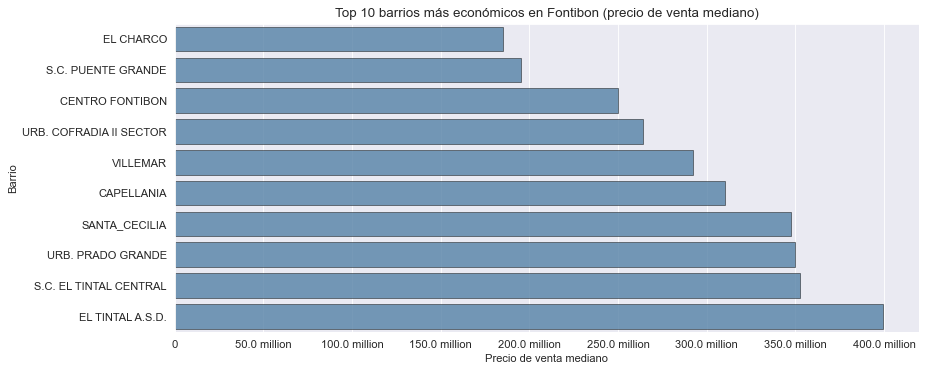

In [57]:
plt.figure(figsize=(12, 5))

sns.barplot(
    top_barrios_economicos_median,
    y=top_barrios_economicos_median.index,
    x='median',
    color='steelblue',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Top 10 barrios más económicos en Fontibon (precio de venta mediano)')
plt.xlabel('Precio de venta mediano')
plt.ylabel('Barrio')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

### Cercania a Transmilenio

In [58]:
fontibon.groupby('is_cerca_estacion_tm')['precio_venta'].describe().applymap(lambda x: humanize.intcomma(x))

,count,mean,std,min,25%,50%,75%,max
is_cerca_estacion_tm,,,,,,,,
0,880.0,"393,813,866.3147727","194,501,896.29682758","119,900,000.0","240,000,000.0","345,000,000.0","520,000,000.0","1,100,000,000.0"
1,84.0,"651,421,710.0238096","168,208,798.3367425","300,000,000.0","561,000,000.0","640,000,000.0","754,944,750.0","1,050,000,000.0"


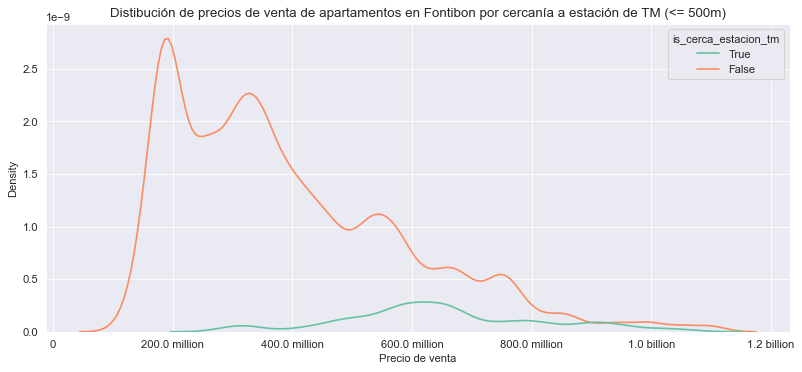

In [59]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    fontibon,
    x='precio_venta',
    bw_adjust=.5,
    hue='is_cerca_estacion_tm',
    hue_order=[True, False],
    palette='Set2',
)

plt.title('Distibución de precios de venta de apartamentos en Fontibon por cercanía a estación de TM (<= 500m)')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

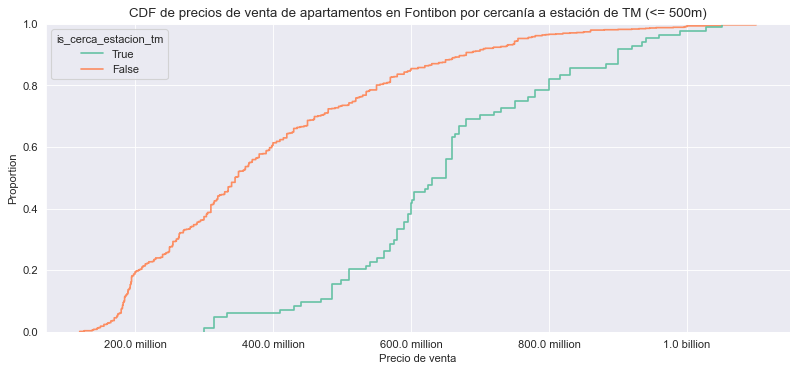

In [60]:
plt.figure(figsize=(12, 5))

sns.ecdfplot(
    fontibon,
    x='precio_venta',
    hue='is_cerca_estacion_tm',
    hue_order=[True, False],
    palette='Set2',
)

plt.title('CDF de precios de venta de apartamentos en Fontibon por cercanía a estación de TM (<= 500m)')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

### Estrato

In [61]:
fontibon.groupby('estrato')['precio_venta'].describe().applymap(lambda x: humanize.intword(x))

,count,mean,std,min,25%,50%,75%,max
estrato,,,,,,,,
2.0,42,181.3 million,24.8 million,119.9 million,165.0 million,181.0 million,194.5 million,236.5 million
3.0,278,237.1 million,79.1 million,126.4 million,184.9 million,209.3 million,264.0 million,640.0 million
4.0,582,481.9 million,162.9 million,195.0 million,345.0 million,450.0 million,587.5 million,997.0 million
5.0,62,762.5 million,195.2 million,230.3 million,614.1 million,752.5 million,900.0 million,1.1 billion


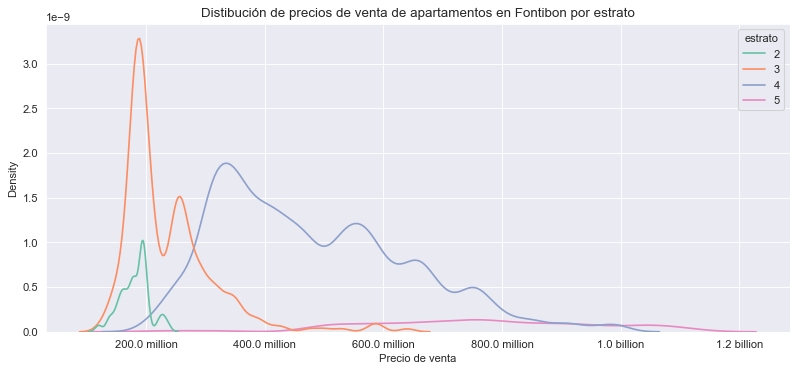

In [62]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    fontibon,
    x='precio_venta',
    bw_adjust=.5,
    hue='estrato',
    hue_order=[2, 3, 4, 5],
    palette='Set2',
)

plt.title('Distibución de precios de venta de apartamentos en Fontibon por estrato')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

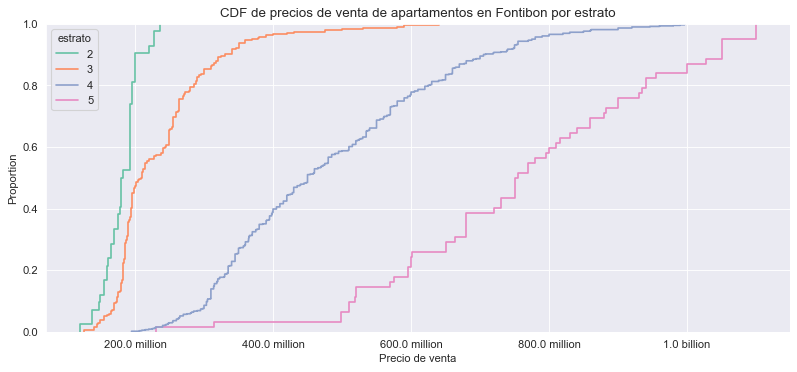

In [63]:
plt.figure(figsize=(12, 5))

sns.ecdfplot(
    fontibon,
    x='precio_venta',
    hue='estrato',
    hue_order=[2, 3, 4, 5],
    palette='Set2',
)

plt.title('CDF de precios de venta de apartamentos en Fontibon por estrato')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

### Antiguedad del apartamento

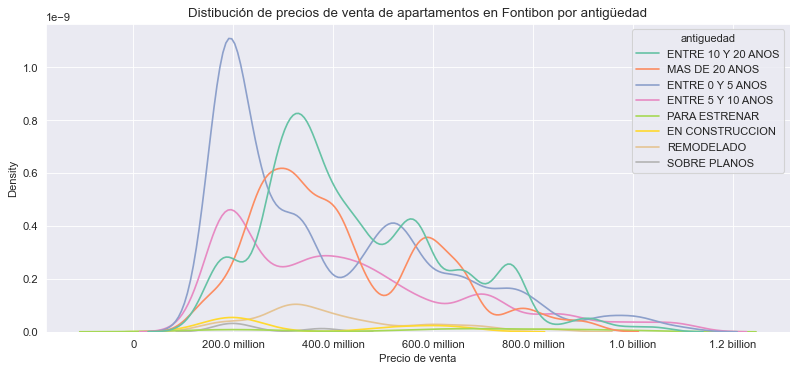

In [64]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    fontibon,
    x='precio_venta',
    bw_adjust=.5,
    hue='antiguedad',
    palette='Set2',
)

plt.title('Distibución de precios de venta de apartamentos en Fontibon por antigüedad')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

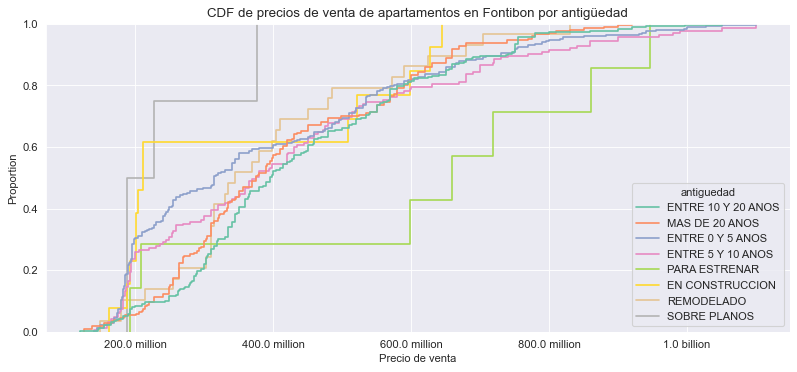

In [65]:
plt.figure(figsize=(12, 5))

sns.ecdfplot(
    fontibon,
    x='precio_venta',
    hue='antiguedad',
    palette='Set2',
)

plt.title('CDF de precios de venta de apartamentos en Fontibon por antigüedad')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

### Estacion de TM Cercana

In [66]:
estacion_tm_cercana.groupby('estacion_tm_cercana')['precio_venta'].describe().sort_values('mean', ascending=False).applymap(lambda x: humanize.intword(x))

,count,mean,std,min,25%,50%,75%,max
estacion_tm_cercana,,,,,,,,
Normandía,20,677.4 million,228.5 million,315.0 million,485.0 million,700.0 million,900.0 million,990.0 million
Av. Rojas – UNISALESIANA,27,666.5 million,169.5 million,315.0 million,570.0 million,650.0 million,774.9 million,1.0 billion
El Tiempo – Cámara de Comercio de Bogotá,30,630.5 million,121.4 million,410.0 million,565.8 million,627.5 million,660.0 million,1.1 billion
Modelia,6,610.0 million,165.4 million,300.0 million,605.0 million,637.5 million,692.5 million,780.0 million
Salitre - El Greco,1,600.0 million,NaN,600.0 million,600.0 million,600.0 million,600.0 million,600.0 million


In [67]:
estacion_tm_cercana_stats_mean = estacion_tm_cercana.groupby('estacion_tm_cercana')['precio_venta'].describe().sort_values('mean', ascending=False)
estacion_tm_cercana_stats_median = estacion_tm_cercana.groupby('estacion_tm_cercana')['precio_venta'].describe().sort_values('50%', ascending=False)

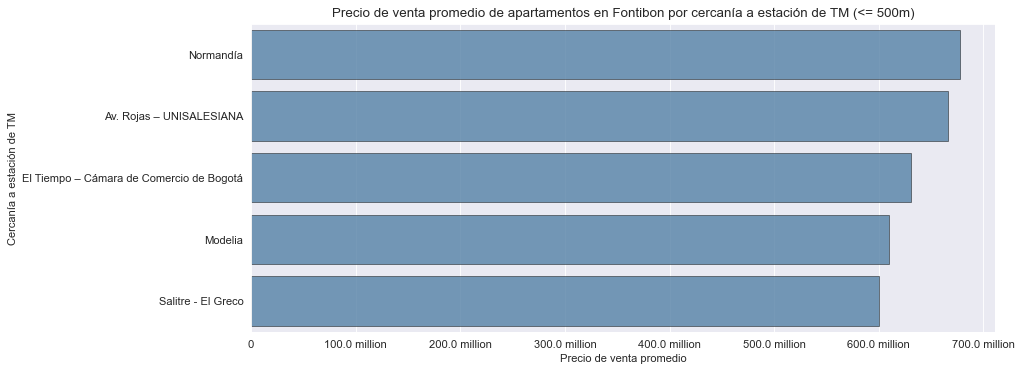

In [68]:
plt.figure(figsize=(12, 5))

sns.barplot(
    estacion_tm_cercana_stats_mean,
    y=estacion_tm_cercana_stats_mean.index,
    x='mean',
    color='steelblue',
    # palette='Set1',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Precio de venta promedio de apartamentos en Fontibon por cercanía a estación de TM (<= 500m)')
plt.xlabel('Precio de venta promedio')
plt.ylabel('Cercanía a estación de TM')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

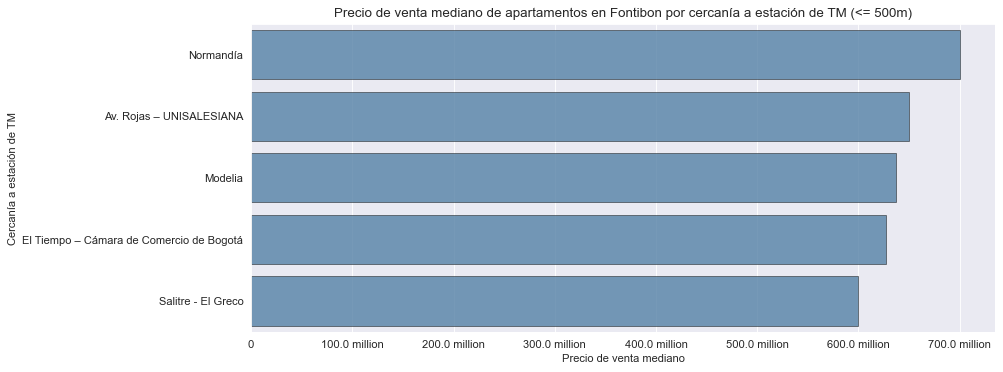

In [69]:
plt.figure(figsize=(12, 5))

sns.barplot(
    estacion_tm_cercana_stats_median,
    y=estacion_tm_cercana_stats_median.index,
    x='50%',
    color='steelblue',
    # palette='Set1',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Precio de venta mediano de apartamentos en Fontibon por cercanía a estación de TM (<= 500m)')
plt.xlabel('Precio de venta mediano')
plt.ylabel('Cercanía a estación de TM')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

<Figure size 960x400 with 0 Axes>

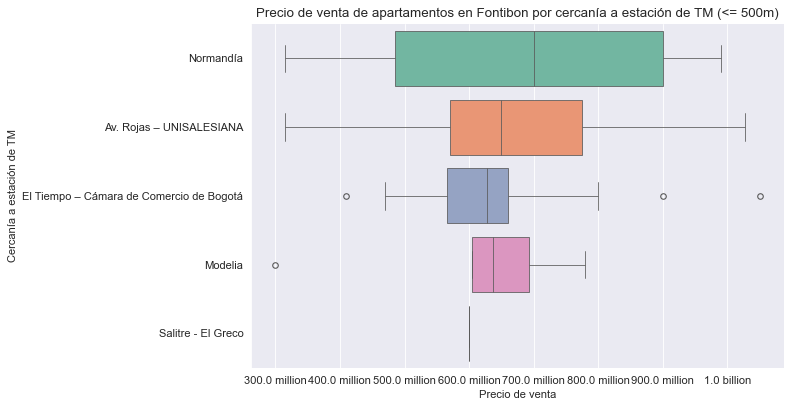

In [70]:
plt.figure(figsize=(12, 5))

sns.catplot(
    data=estacion_tm_cercana,
    x='precio_venta',
    y='estacion_tm_cercana',
    kind='box',
    height=5,
    aspect=2,
    palette='Set2',
    orient='h',
    linewidth=.7,
)

plt.title('Precio de venta de apartamentos en Fontibon por cercanía a estación de TM (<= 500m)')
plt.xlabel('Precio de venta')
plt.ylabel('Cercanía a estación de TM')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

### Precios Anteriores Vs Actuales

## Antiguedad

In [71]:
fontibon.antiguedad.value_counts()

antiguedad
ENTRE 0 Y 5 ANOS      281
ENTRE 10 Y 20 ANOS    259
MAS DE 20 ANOS        206
ENTRE 5 Y 10 ANOS     165
REMODELADO             29
EN CONSTRUCCION        13
PARA ESTRENAR           7
SOBRE PLANOS            4
Name: count, dtype: int64

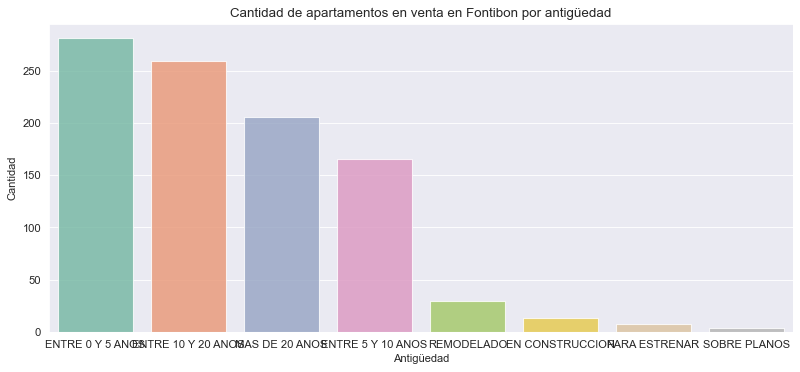

In [72]:
plt.figure(figsize=(12, 5))

sns.countplot(
    fontibon,
    x='antiguedad',
    order=fontibon.antiguedad.value_counts().index,
    palette='Set2',
    # edgecolor='black',
    # linewidth=.5,
    alpha=.8,
)

plt.title('Cantidad de apartamentos en venta en Fontibon por antigüedad')
plt.xlabel('Antigüedad')
plt.ylabel('Cantidad')
plt.show()

### Barrios

In [73]:
fontibon.groupby('antiguedad')['barrio'].describe()

,count,unique,top,freq
antiguedad,,,,
EN CONSTRUCCION,12,3,EL CHARCO,7
ENTRE 0 Y 5 ANOS,280,42,EL TINTAL A.S.D.,39
ENTRE 10 Y 20 ANOS,259,35,EL TINTAL A.S.D.,45
ENTRE 5 Y 10 ANOS,165,26,EL CHARCO,40
MAS DE 20 ANOS,206,35,CIUDAD SALITRE OCCIDENTAL,27
PARA ESTRENAR,5,1,URB. INDUSTRIAL MONTEVIDEO,5
REMODELADO,29,18,URB. PRADO GRANDE,7
SOBRE PLANOS,4,3,FLOTA LA MACARENA,2


In [74]:
fontibon.groupby('antiguedad')['area'].describe().apply(lambda x: round(x,1))

,count,mean,std,min,25%,50%,75%,max
antiguedad,,,,,,,,
EN CONSTRUCCION,13.0,47.9,15.1,28.2,37.7,40.7,59.4,73.4
ENTRE 0 Y 5 ANOS,281.0,58.8,20.5,22.5,45.0,50.4,72.0,137.0
ENTRE 10 Y 20 ANOS,259.0,74.2,18.2,36.0,60.0,71.0,89.0,127.0
ENTRE 5 Y 10 ANOS,165.0,71.8,24.7,26.4,50.0,69.0,85.0,138.0
MAS DE 20 ANOS,206.0,75.3,21.7,20.0,60.9,70.5,90.0,135.0
PARA ESTRENAR,7.0,60.9,17.3,39.8,49.1,61.5,70.2,86.5
REMODELADO,29.0,69.2,19.8,36.0,58.2,68.2,73.0,123.5
SOBRE PLANOS,4.0,43.1,11.5,36.0,36.0,38.2,45.3,60.0


In [75]:
fontibon.groupby('barrio')['antiguedad'].describe().sort_values(by='count', ascending=False).head(10)

,count,unique,top,freq
barrio,,,,
EL TINTAL A.S.D.,120,6,ENTRE 10 Y 20 ANOS,45
EL CHARCO,102,6,ENTRE 5 Y 10 ANOS,40
LA ESPERANZA_,92,5,ENTRE 10 Y 20 ANOS,39
URB. PRADO GRANDE,83,4,ENTRE 10 Y 20 ANOS,42
CIUDAD SALITRE OCCIDENTAL,49,5,MAS DE 20 ANOS,27
CAPELLANIA,40,4,MAS DE 20 ANOS,21
LA ESPERANZA NORTE,37,3,ENTRE 0 Y 5 ANOS,23
CIUDAD SALITRE,31,4,MAS DE 20 ANOS,25
MODELIA OCCIDENTAL,29,5,MAS DE 20 ANOS,18


### Estrato

In [76]:
fontibon.groupby('barrio').agg(
    count=('barrio', 'count'),
    mean=('estrato', 'mean'),
    median=('estrato', 'median'),
    std=('estrato', 'std'),
).sort_values(by='count', ascending=False).head(10)

,count,mean,median,std
barrio,,,,
EL TINTAL A.S.D.,120,3.950000,4.0,0.313559
EL CHARCO,102,2.745098,3.0,0.437958
LA ESPERANZA_,92,3.956522,4.0,0.293259
URB. PRADO GRANDE,83,3.975904,4.0,0.154281
CIUDAD SALITRE OCCIDENTAL,49,4.244898,4.0,0.521641
CAPELLANIA,40,3.825000,4.0,0.384808
LA ESPERANZA NORTE,37,4.945946,5.0,0.229243
CIUDAD SALITRE,31,4.064516,4.0,0.249731
VILLEMAR,29,3.137931,3.0,0.441114


## Barrios

In [77]:
fontibon.groupby('barrio')['codigo'].count().sort_values(ascending=False).to_frame().head(10)

,codigo
barrio,
EL TINTAL A.S.D.,120
EL CHARCO,102
LA ESPERANZA_,92
URB. PRADO GRANDE,83
CIUDAD SALITRE OCCIDENTAL,49
CAPELLANIA,40
LA ESPERANZA NORTE,37
CIUDAD SALITRE,31
VILLEMAR,29


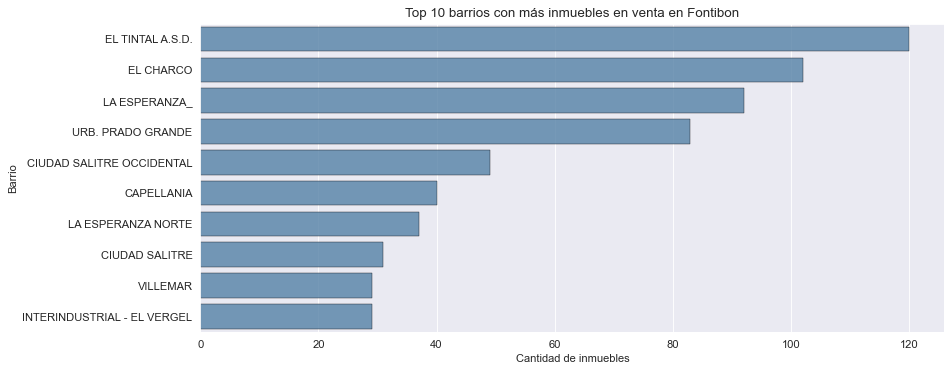

In [78]:
plt.figure(figsize=(12, 5))

sns.barplot(
    data=fontibon.groupby('barrio')['codigo'].count().sort_values(ascending=False).to_frame().head(10),
    x='codigo',
    y=fontibon.groupby('barrio')['codigo'].count().sort_values(ascending=False).to_frame().head(10).index,
    # palette='Set2',
    color='steelblue',
    orient='h',
    edgecolor='black',
    linewidth=.4,
    alpha=.8
)

plt.title('Top 10 barrios con más inmuebles en venta en Fontibon')
plt.xlabel('Cantidad de inmuebles')
plt.ylabel('Barrio')
plt.show()

In [84]:
# apartamentos mas costosos por cercania a parque
parque_cercano_stats = fontibon.groupby('parque_cercano')['precio_venta'].describe().sort_values('mean', ascending=False)
parque_cercano_stats

,count,mean,std,min,25%,50%,75%,max
parque_cercano,,,,,,,,
PARQUE VECINAL URBANIZACIÓN SALITRE (GRECO),2.0,6.650000e+08,9.192388e+07,600000000.0,632500000.0,665000000.0,697500000.0,7.300000e+08
PARQUE ZONAL SAUZALITO,106.0,6.456851e+08,1.644769e+08,236500000.0,542500000.0,630000000.0,749250000.0,1.100000e+09
PARQUE VECINAL CARLOS LLERAS (EL FUEGO),103.0,5.978890e+08,1.718796e+08,215000000.0,510000000.0,570000000.0,697000000.0,1.100000e+09
PARQUE ZONAL CANAL BOYACA,148.0,5.029670e+08,2.101406e+08,193000000.0,326250000.0,462500000.0,664750000.0,1.050000e+09
PARQUE VECINAL VILLA ALSACIA,61.0,4.685626e+08,1.514150e+08,150000000.0,340000000.0,530000000.0,565000000.0,1.050000e+09
PARQUE VECINAL MODELIA SECTOR A,93.0,4.559577e+08,1.638658e+08,160000000.0,350000000.0,399000000.0,480000000.0,9.900000e+08
PARQUE VECINAL VILLA HELENA VILLEMAR,258.0,3.365319e+08,9.625173e+07,140000000.0,264000000.0,319250000.0,395000000.0,7.500000e+08
PARQUE ZONAL ATAHUALPA,6.0,2.489167e+08,5.472515e+07,167000000.0,217375000.0,260000000.0,277500000.0,3.200000e+08
PARQUE ZONAL CARMEN DE LA LAGUNA,31.0,2.108794e+08,4.673606e+07,126380000.0,187235000.0,210000000.0,233686640.0,3.800000e+08


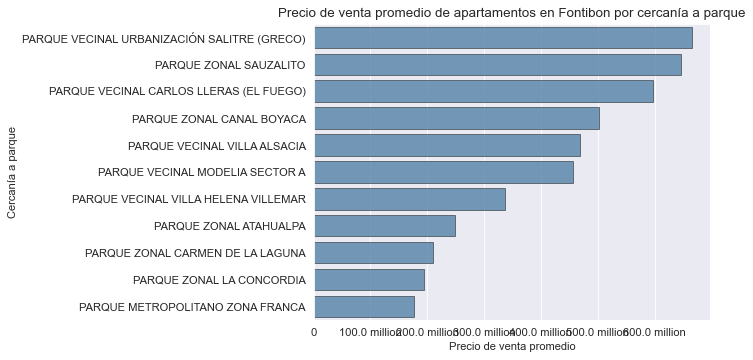

In [85]:
sns.barplot(
    parque_cercano_stats,
    y=parque_cercano_stats.index,
    x='mean',
    color='steelblue',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Precio de venta promedio de apartamentos en Fontibon por cercanía a parque')
plt.xlabel('Precio de venta promedio')
plt.ylabel('Cercanía a parque')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()